In [1]:
import os
import re
import codecs
import pathlib

import flag
import country_converter as coco

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# import a clean function data
def clean_text(text):
    return text.strip()

## Task

- Split the main text.txt file into individual news report files, using the textID, the corresponding date and country for name of the news report file.
- Create country/year folders to push each file in its proper country/year.

In [3]:
# read in sources data
# data is separated by 1 or 2 tabs. 
sources = pd.read_csv("data/raw/sources.txt", 
                      sep="\t{1,2}", encoding="ISO-8859-1", skiprows=2, engine='python')

# rename columns
sources.columns = ["id", "n_words", "date", "country", "website", "url", "title"]

# date column -> pandas.DateTime
sources["date"] = pd.to_datetime(sources["date"], format="%y-%m-%d")

print(sources.shape)
sources.head()

(2960, 7)


,id,n_words,date,country,website,url,title
0,11241,397,2013-01-06,US,Kotaku,http://kotaku.com/5973495/author-of-the-warrio...,"Author of The Warriors, Cult Film Adapted to H..."
1,11242,757,2013-01-06,US,Michigan Radio,http://michiganradio.org/post/thats-what-they-...,That's What They Say: Dialect Society chooses ...
2,11243,755,2013-01-06,US,New York Daily News,http://www.nydailynews.com/life-style/eats/bes...,Best of New York: Croissant
3,11244,1677,2013-01-06,US,OregonLive.com,http://www.oregonlive.com/performance/index.ss...,Reflecting on a quarter-century of growth in P...
4,21242,794,2013-01-11,US,Ars Technica,http://arstechnica.com/gadgets/2013/01/ask-ars...,Ask Ars: Does Facebook auto-delete content aft...


In [4]:
# read in text data
# find lines that start with @@, extract id and text from them
with open("data/raw/text.txt", "r") as f:
    text = pd.DataFrame(
        [re.search("(\d+)\s(.*)", l[2:]).groups() for l in f.readlines() if l.startswith("@@")],
        columns=["id", "text"]
    )
    f.close()

# id should be an integer
text["id"] = text["id"].astype(int)

# clean text here
text["text"] = text["text"].apply(clean_text)
text['text'] = text.text.str.replace('<[^<]+?>', '')
text['text'] = text.text.str.replace("\n", '')
text['text'] = text.text.str.replace("@ @ @ @ @ @ @ @ @ @ ", '')
text['text'] = text.text.replace(" '", "'")
text['text'] = text.text.replace(" '", "'")
text['text'] = text.text.replace(" .", ".")
text['text'] = text.text.replace(" ,", ",")
text['text'] = text.text.replace("  ", "")
text['text'] = text.text.replace(" n't", "n't")
text['text'] = text.text.str.lower()
text["text"] = text["text"].apply(clean_text)
print(text.shape)
text.head()

(2914, 2)


,id,text
0,11241,"sol yurick , the writer whose 1965 novel "" the..."
1,11242,that 's what they say : dialect society choose...
2,11243,a sublime croissant at french tart in grant ci...
3,11244,reflecting on a quarter-century of growth in p...
4,21242,ask ars : does facebook auto-delete content af...


In [5]:
# combine the data
reports = sources.merge(text, on="id", how="outer")
reports["year"] = reports["date"].dt.strftime("%Y")

In [6]:
#Total Articles per country with Flags
cc = coco.CountryConverter()
val_counts = reports.country.value_counts()

for country in [x for x in reports.country.unique().tolist() if str(x) != 'nan'] :
    if country:
        print(flag.flag(country), country, '| total counts: ',val_counts[country], ' | ', coco.convert(names=country, to='name_short'), )

AttributeError: module 'flag' has no attribute 'flag'

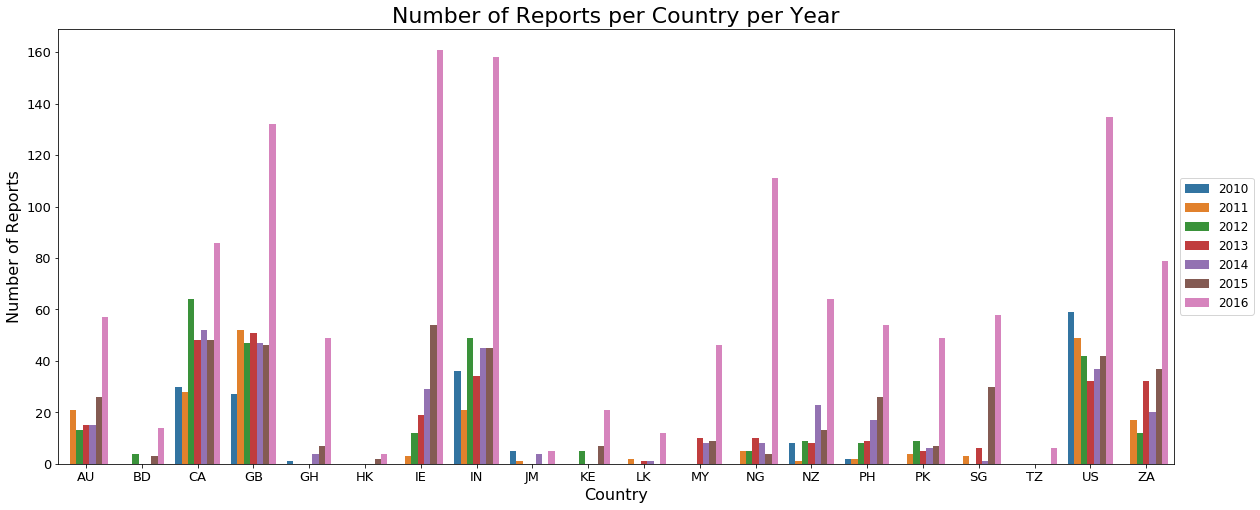

In [7]:
groups = reports.groupby(["country", "year"]).id.count().to_frame().reset_index()

fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(
    x="country", 
    y="id", 
    hue="year",
    data=groups,
    ax=ax
)

ax.set_xlabel("Country", fontsize=16)
ax.set_ylabel("Number of Reports", fontsize=16)
ax.set_title("Number of Reports per Country per Year", fontsize=22)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12);

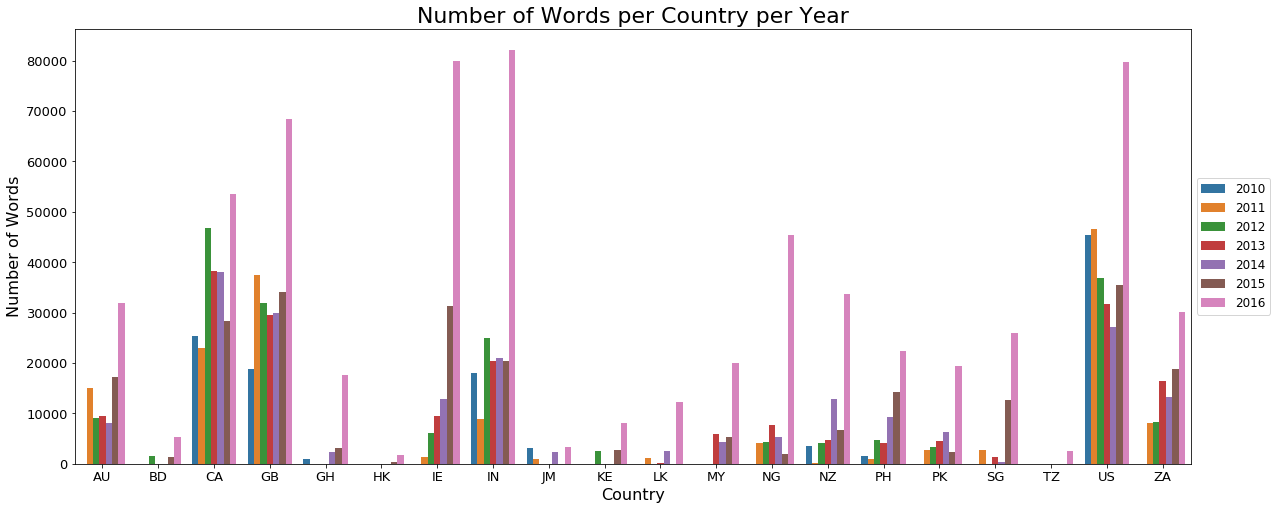

In [8]:
words_per_year = reports[['n_words','year','country']].groupby(['country','year']).sum().reset_index()

fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(
    x="country", 
    y="n_words", 
    hue="year",
    data=words_per_year,
    ax=ax
)
ax.set_xlabel("Country", fontsize=16)
ax.set_ylabel("Number of Words", fontsize=16)
ax.set_title("Number of Words per Country per Year", fontsize=22)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12);

Example, news report with textID 11241:
- pushed to a file with name 11241_US_13-01-06.txt. 
- 11241_US_13-01-06.txt should be in the US/2006 folder. 

In [9]:
def get_report_folder(report: pd.Series) -> str:
    """Get the folder a report belongs in as COUNTRY/YEAR"""
    if not pd.isna(report.date):
        year = report.date.strftime("%Y")
        return f"{report.country}/{year}"
    else:
        return f"{report.country}"

def get_report_name(report: pd.Series) -> str:
    """Get the file name for a report as ID_COUNTRY_DATE.txt"""
    if not pd.isna(report.date):
        date_string = report.date.strftime("%d-%m-%y")
        return f"{report.id}_{report.country}_{date_string}.txt"
    else:
        return f"{report.id}_{report.country}.txt"

def export_report(report: pd.Series, path=None) -> str:
    """Export a report to the correct folder with the correct name
    
    Keyword Arguments:
        path {str, optional}: a parent path to the folder. The directory you want the data all saved to.
        
    Returns:
        the output path FOLDER/FILE.txt, excluding the path argument.
    """
    folder = get_report_folder(report)
    file = get_report_name(report)
    
    full_path = f"{path + '/' if path else ''}{folder}"
    # create the folder, if it doesn't already exist
    pathlib.Path(full_path).mkdir(parents=True, exist_ok=True)
    
    # write the file
    with codecs.open(f"{full_path}/{file}", "w", "ISO-8859-1") as f:
        if not pd.isna(report.text):
            title = report.title if not pd.isna(report.title) else ""
            url = report.url if not pd.isna(report.url) else ""
            f.writelines([title, "\n", url, "\n\n", report.text])
        f.close()
    
    return f"{folder}/{file}"

In [10]:
reports["export_folder"] = reports.apply(export_report, axis=1, path="data/clean")

reports.to_csv("data/clean/all_reports.csv", index=False)
reports

,id,n_words,date,country,website,url,title,text,year,export_folder
0,11241,397.0,2013-01-06,US,Kotaku,http://kotaku.com/5973495/author-of-the-warrio...,"Author of The Warriors, Cult Film Adapted to H...","sol yurick , the writer whose 1965 novel "" the...",2013,US/2013/11241_US_06-01-13.txt
1,11242,757.0,2013-01-06,US,Michigan Radio,http://michiganradio.org/post/thats-what-they-...,That's What They Say: Dialect Society chooses ...,that 's what they say : dialect society choose...,2013,US/2013/11242_US_06-01-13.txt
2,11243,755.0,2013-01-06,US,New York Daily News,http://www.nydailynews.com/life-style/eats/bes...,Best of New York: Croissant,a sublime croissant at french tart in grant ci...,2013,US/2013/11243_US_06-01-13.txt
3,11244,1677.0,2013-01-06,US,OregonLive.com,http://www.oregonlive.com/performance/index.ss...,Reflecting on a quarter-century of growth in P...,reflecting on a quarter-century of growth in p...,2013,US/2013/11244_US_06-01-13.txt
4,21242,794.0,2013-01-11,US,Ars Technica,http://arstechnica.com/gadgets/2013/01/ask-ars...,Ask Ars: Does Facebook auto-delete content aft...,ask ars : does facebook auto-delete content af...,2013,US/2013/21242_US_11-01-13.txt
...,...,...,...,...,...,...,...,...,...,...
3005,15031244,NaN,NaT,NaN,NaN,NaN,NaN,india continued to tear into pakistan in the g...,NaN,nan/15031244_nan.txt
3006,15171241,NaN,NaT,NaN,NaN,NaN,NaN,president john dramani mahama has reminded his...,NaN,nan/15171241_nan.txt
3007,15171242,NaN,NaT,NaN,NaN,NaN,NaN,list of 23 ndc members expelled for going inde...,NaN,nan/15171242_nan.txt
3008,15171243,NaN,NaT,NaN,NaN,NaN,NaN,messi should not captain argentina - passarell...,NaN,nan/15171243_nan.txt


-----------------------------------------

In [20]:
BBC_df = reports[reports['website'] == 'BBC News']

In [21]:
BBC_df['vector'] = BBC_df['text'].str.lower().str.split()

/Users/leo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [26]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [27]:
BBC_df['vector'] = BBC_df['vector'].apply(lambda x: [item for item in x if item not in stop])

/Users/leo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(BBC_df['vector'])
print(vectorizer.get_feature_names())

AttributeError: 'list' object has no attribute 'lower'

In [16]:
reports['website'].value_counts()[reports['website'].value_counts() > 10]

Times of India               95
Telegraph.co.uk              53
Independent Online           49
Daily Mail                   46
Irish Independent            41
Stuff.co.nz                  39
Irish Times                  32
BBC News                     31
Inquirer.net                 29
The Hindu                    28
The Guardian                 27
Irish Examiner               27
GhanaWeb                     26
Toronto Star                 25
Goal.com                     25
Globe and Mail               23
The Independent              21
News24                       20
ABC Online                   19
The Nation Newspaper         19
Otago Daily Times            18
Vanguard                     17
InterAksyon                  17
CBC.ca                       16
The42                        16
Mirror.co.uk                 15
Pakistan Observer            14
Daily News &amp; Analysis    14
The Straits Times            14
Irish Mirror                 13
Catch News                   13
Free Mal

In [48]:
reports['website'].value_counts()

Times of India          95
Telegraph.co.uk         53
Independent Online      49
Daily Mail              46
Irish Independent       41
                        ..
EconomyNext              1
lehighvalleylive.com     1
Evening Echo Cork        1
Consequence of Sound     1
Glamour                  1
Name: website, Length: 1104, dtype: int64

In [28]:
sum(reports['text'] == np.nan)

0

In [ ]:
reports_trim = reports[reports['text'] == ]

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer(stop_words='english')
x = v.fit_transform(reports[reports['text'].notnull()]['text'])

In [30]:
x

<2914x59317 sparse matrix of type '<class 'numpy.float64'>'
	with 568967 stored elements in Compressed Sparse Row format>

In [31]:
feature_array = np.array(v.get_feature_names())
tfidf_sorting = np.argsort(x.toarray()).flatten()[::-1]

In [33]:
x.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [52]:
len(v.get_feature_names())

59317